In [1]:
import time
import random 
import dask
from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
from dask_jobqueue import SLURMCluster

/users/dmoi/.local/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [49]:
from dask.distributed import get_worker

def annoying_function(r , err=.5 ):
    if err*100 < r:
        #err
        raise ValueError  # shorthand for 'raise ValueError()'
    else:
        return 'success',   r
        


In [14]:

NCORE = 2
njobs = 100

print('deploying cluster')
cluster = SLURMCluster(
    walltime='1:00:00',
    n_workers = 1,
    cores=NCORE,
    processes = NCORE,
    interface='ib0',
    memory="10GB" ,
    env_extra=[
    'source /work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/etc/profile.d/conda.sh',
    'conda init',
    'conda activate ML2'
    ],
    scheduler_options={'interface': 'ens3f0' }
)


print(cluster.job_script())
#cluster.adapt(minimum=10, maximum=30)
cluster.scale(jobs=10)

#cluster.adapt(minimum=1, maximum=2)

time.sleep(5)
print(cluster)
print(cluster.dashboard_link)
client = Client(cluster , timeout='1000s' , set_as_default=True )

deploying cluster
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -n 1
#SBATCH --cpus-per-task=2
#SBATCH --mem=10G
#SBATCH -t 1:00:00
source /work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/etc/profile.d/conda.sh
conda init
conda activate ML2
/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/bin/python -m distributed.cli.dask_worker tcp://10.203.100.166:33835 --nthreads 1 --nprocs 2 --memory-limit 4.66GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33931 instead
  warnings.warn(


SLURMCluster(f177d191, 'tcp://10.203.100.166:33835', workers=0, threads=0, memory=0 B)
http://10.203.100.166:33931/status


In [15]:
cluster.scale(jobs=njobs)

In [50]:
cluster.adapt(minimum=10, maximum=20)


In [64]:
print(cluster)

SLURMCluster(f177d191, 'tcp://10.203.100.166:33835', workers=10, threads=10, memory=46.60 GiB)


In [65]:
samples = 100
futures =[]
for i in range(samples):
    res = client.submit( annoying_function , random.randint(0,100) )
    futures.append(res)

In [ ]:
from dask.distributed import as_completed


finished = as_completed(futures)
done = []
failed = []

while True:
    failed = []
    for i,f in enumerate(finished):
        try:
            mats = f.result()
            print(mats)
            done.append(time.time())
        except:
            print('err')
            failed.append(f)
    
    client.retry(failed)  
    if len(failed) == 0 :
        break
    finished = as_completed(failed)

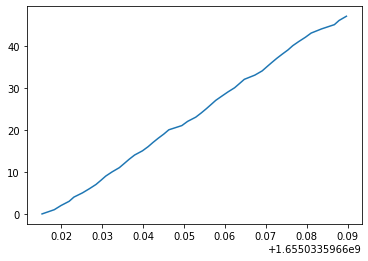

In [60]:
from matplotlib import pyplot as plt

import numpy as np
plt.plot( done , np.arange(len(done))  )

In [2]:


import dask 
import dendropy

####small parsimony functions ##########
def process_node_smallpars_1(node):
    #go from leaves up and generate character sets
    if node.symbols is None:
        for child in node.child_nodes():
            if child.symbols is None:
                process_node_smallpars_1(child)
        node.symbols = { }
        node.scores = { }
        for pos in child.symbols:
            symbols = set.intersection( * [ child.symbols[pos] for child in node.child_nodes( ) ] )
            if len(symbols) == 0:
                symbols = set.union( * [ child.symbols[pos] for child in node.child_nodes( ) ] )
            node.symbols[pos] = symbols
            node.scores[pos] = { }
            for c in allowed_symbols:
                if c not in node.symbols[pos]:
                    #add trnasition mat here if needed
                    score = min(  [ child.scores[pos][c] for child in node.child_nodes()])+1
                else:
                    score = min(  [ child.scores[pos][c] for child in node.child_nodes() ] )
                node.scores[pos][c] = score

                
def process_node_smallpars_2(node , verbose = False):
    
    #assign the most parsimonious char from children
    if node.char is None:
        if node.parent_node:
            #node has parent
            node.char = {}
            node.event = {}
            node.eventype= {}
            node.AAevent = None

            for pos in node.scores:
                node.char[pos] = min(node.scores[pos], key=node.scores[pos].get)
                if node.parent_node.char[pos] == node.char[pos]:
                    node.event[pos] = 0
                else:
                    if node.scores[pos][node.parent_node.char[pos]] == node.scores[pos][node.char[pos]] :
                        node.char[pos] = node.parent_node.char[pos]
                        node.event[pos] = 0
                    else:
                        node.event[pos] = 1
                        node.eventype[pos] = transition_dict[node.parent_node.char[pos]+node.char[pos]]
            if len(node.char) == 3:
                node.AA = str(Seq.Seq(b''.join([ node.char[pos] for pos in node.char ]).decode() ).translate())
            else:
                node.AA = None
            if node.AA and node.AA != node.parent_node.AA:
                if node.parent_node.AA+node.AA in transitiondict_AA:
                    node.AAevent = transitiondict_AA[node.parent_node.AA+node.AA]
                    if verbose == True:
                        print( node.parent_node.AA , ' -> ' ,  node.AA)
        else:
            #root node
            node.char = {}
            node.event= {}
            node.eventype = {}
            node.AAevent = 0
            for pos in node.scores:
                node.char[pos] = min(node.scores[pos], key=node.scores[pos].get)
                node.event[pos] = 0
            if nucleotides_only == False:
                node.AA = Seq.Seq(b''.join([ node.char[pos] for pos in [0,1,2] ]).decode() ).translate()
            else:
                node.AA = 'G'
        #down one level
        for child in node.child_nodes():
            if child.char is None:
                process_node_smallpars_2(child)

@dask.delayed(pure=False)
def delayed_send(data):
    return lzma.compress(pickle.dumps(data))

@dask.delayed(pure=False)
def delayed_receive(data):
    return pickle.loads( lzma.decompress(data) )


@dask.delayed(pure = False)
def prepare_tree(tree , child_nodes , alnfile , posvec ):
    #prepare a subtree
    for idx in posvec:
        with h5py.File(alnfile +'.h5', 'r') as hf:
            align_array = hf['MSA2array'] 
            df = align_array[idx  , : ]
        alnmax = df.shape[1]
        for codonpos in [0,1,2]:
            alncol = df[codonpos , : ]
            for l in t.leaf_nodes():
                #setup for small_pars1
                l.calc[codonpos] = True
                l.event[codonpos] = 0
                l.scores[codonpos] = { c:10**10 for c in allowed_symbols }
                l.symbols[codonpos] =  allowed_symbols
                if l.aln_row and l.aln_row < alnmax and l.aln_row not in del_genomes:

                    char = alncol[ l.aln_row ]

                    if char.upper() in allowed_symbols:
                        l.symbols[codonpos] = { char }
                        l.scores[codonpos][char] = 0
                    else:
                        char = None
                        l.symbols[codonpos] =  allowed_symbols
                
                elif: l.matrow in childnodes:
                    
                    child_nodes
                else:
                
                    char = None
                    l.symbols[codonpos] =  allowed_symbols
                l.char[codonpos] = min(l.scores[codonpos], key=l.scores[codonpos].get)
    return tree
                              
                
@dask.delayed(pure=False)
def calculate_small_parsimony(t ,  posvec  ,  bootstrap = None , position = 0 , alnfile = None ):
    #df is 3 columns of a codons
    #setup the tree and matrix for each worker
    sys.setrecursionlimit( 10 **9 )
    with open(tree , 'rb') as treein:
        t = pickle.loads(treein.read())    
    #assign leaf values
    #repeat here for bootstrap
    if bootstrap is not None :
        #select portion of random genomes to take out
        del_genomes = set(np.random.randint( len(t.leaf_nodes()) , size= int( len(t.leaf_nodes()) *bootstrap) ) )
    else:
        del_genomes = set([])
    retdfs = []
    #change a subset of leaves to ambiguous characters
    for idx in posvec:
        with h5py.File(alnfile +'.h5', 'r') as hf:
            align_array = hf['MSA2array'] 
            df = align_array[idx  , : ]
        alnmax = df.shape[1]
        for codonpos in [0,1,2]:
            alncol = df[codonpos , : ]
            for l in t.leaf_nodes():
                #setup for small_pars1
                l.calc[codonpos] = True
                l.event[codonpos] = 0
                l.scores[codonpos] = { c:10**10 for c in allowed_symbols }
                l.symbols[codonpos] =  allowed_symbols
                if l.aln_row and l.aln_row < alnmax and l.aln_row not in del_genomes:

                    char = alncol[ l.aln_row ]

                    if char.upper() in allowed_symbols:
                        l.symbols[codonpos] = { char }
                        l.scores[codonpos][char] = 0
                    else:
                        char = None
                        l.symbols[codonpos] =  allowed_symbols
                else:
                    char = None
                    l.symbols[codonpos] =  allowed_symbols
                l.char[codonpos] = min(l.scores[codonpos], key=l.scores[codonpos].get)
        #upq
        process_node_smallpars_1(t.seed_node)
        #down
        process_node_smallpars_2(t.seed_node)
        #collect events
        eventdict = {}
        AAeventindex = [ n.matrow for n in t.nodes() if n.AAevent  ]
        AAeventypes = [ n.AAevent for n in t.nodes() if n.AAevent  ]
        for codonpos,i in enumerate(t.seed_node.char):
            eventindex = [ n.matrow for n in t.nodes() if n.event[codonpos] > 0 ]
            eventtypes = [ n.eventype[codonpos] for n in t.nodes() if n.event[codonpos] > 0 ]
            if codonpos==0:
                eventdict[i] = { 'type': eventtypes , 'index' : eventindex , 'AAeventindex':AAeventindex , 'AAeventypes': AAeventypes  }
            else:
                eventdict[i] = { 'type': eventtypes , 'index' : eventindex , 'AAeventindex':[] , 'AAeventypes': [] }
            eventdict[i]['codon_pos'] = codonpos
            eventdict[i]['column'] = idx[0] + codonpos
        retdf = pd.DataFrame.from_dict(eventdict, orient = 'index' )
        retdfs.append(retdf)
    return retdfs , t.seed_node.char


###compute spares matrics from results #######################################################################
@dask.delayed(pure=False)
def compute_matrices(  retdfs  ,  matsize , transitionsNT = 12 , transitionsAA = 380      ):
    count = 0
    AA_mutation = None
    nucleotide_mutation = None
    for resdf in retdfs:
        for idx,row in resdf.iterrows():
            #get next job completed
            eventtypes , eventindex , AAeventindex , AAeventypes= row[['type' , 'index' , 'AAeventindex' , 'AAeventypes']]
            eventtypes , eventindex , AAeventindex , AAeventypes = [ list(a)  for a in [eventtypes , eventindex , AAeventindex , AAeventypes ] ]
            #save each position to event mats
            col = row.column
            if nucleotide_mutation is not None:
                nucleotide_mutation  += sparseND.COO( coords =  ( eventindex  , [ col for i in range(len(eventindex)) ]  , eventtypes ) , data = np.ones( len(eventindex) ) , shape = (matsize[0] , matsize[1] , transitionsNT)  )
            else:
                nucleotide_mutation  =  sparseND.COO( coords = ( eventindex ,  [ col for i in range(len(eventindex)) ]    , eventtypes ) , data = np.ones( len(eventindex) ) , shape = (matsize[0] , matsize[1] , transitionsNT )  )
            if AA_mutation  is not None:
                AA_mutation  += sparseND.COO( coords =  ( AAeventindex ,  [ col for i in range(len(AAeventindex)) ]   , AAeventypes ) , data = np.ones(len(AAeventindex)  ) , shape = (matsize[0] , matsize[1] , transitionsAA )   )
            else:
                AA_mutation  = sparseND.COO( coords =  ( AAeventindex ,  [ col for i in range(len(AAeventindex)) ]  , AAeventypes ) , data = np.ones(len(AAeventindex)    ) , shape = (matsize[0] , matsize[1] , transitionsAA )   )
    return  nucleotide_mutation, AA_mutation


In [ ]:
NCORE = 10
njobs = 1
print('testing')
cluster = LocalCluster(n_workers = NCORE )
#cluster.adapt(minimum = 50,  maximum=NCORE)
print(cluster.dashboard_link)
client = Client(cluster)

In [ ]:
#
def process_node_down_sectors(node, sector = 0, breakpt = 10 , total = 0 , topnode = None , current_dict = None):
    node.sector = sector
    if sector == 0 :
        global count
        global sector_dict
        sector_dict = {node:None}
        count = 0
    total += len(node.child_nodes())
    for i,child in enumerate(node.child_nodes()):
        if total > breakpt:
            if len(child.child_nodes())>0:
                #new sector w new total
                count+=1
                if sector == 0:
                    topnode = node
                    if sector_dict[node] is None:
                        sector_dict[topnode] = {}
                    sector_dict[topnode][child] = None
                    current_dict = sector_dict[topnode][child]
                else:
                    if current_dict[topnode] is None:
                        current_dict[topnode] = {}
                    current_dict[topnode][child] = None
                    current_dict = current_dict[topnode][child]
                topnode = child
                process_node_down(child, count , total = 0 , breakpt = breakpt , topnode =topnode , current_dict = current_dict )
            else:
                #leaf
                process_node_down(child, count , total = 0 , breakpt = breakpt , topnode =topnode , current_dict = current_dict)
        else:
            process_node_down(child, count , total = total , breakpt = breakpt, topnode =topnode , current_dict = current_dict)
    return sector_dict

#
def get_sectors(tree, breakpt = 10):
    treedict = {}
    #make sector tree dict
    treedict = process_node_down( tree.seed_node , sector = 0, breakpt = breakpt )
    row = [n.matrow for n in tree.nodes()]
    col = [n.sector for n in tree.nodes()]
    data = np.ones((len(row)))
    sectormat = scipy.sparse.csc_matrix( (data,(row,col)) )
    return sectormat , treedict


#
def process_node_down_dict(treedict , alnfile, tree ):
    
    node.sector = sector
    if sector == 0 :
        global count
        count = 0
    for i,child in enumerate(treedict):
        if treedict[child] is not None:
            process_node_down_dict(treedict , alnfile, tree)
        else:
            
            retdfs , nodechar = calculate_small_parsimony(t ,  posvec  ,  bootstrap = None , position = 0 , alnfile = None )
            mats = 
            
            
        if total > breakpt:
            if len(child.child_nodes())>0:
                #new sector w new total
                count+=1
                process_node_down(child, count , total = 0 , breakpt = breakpt)
                yield  node,child
                
            else:
                #leaf
                process_node_down(child, count , total = 0 , breakpt = breakpt)
        else:
            process_node_down(child, count , total = total , breakpt = breakpt)

    
#
def return_delayed_objects(treedict, alnfile , tree ):
        

In [ ]:
#split smallpars into sectors



